In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # This optional package makes plots prettier

import openmc

## The statepoint file

Let's begin by loading the statepoint HDF5 file for batch 100 into the Python API's `openmc.StatePoint` class:

In [2]:
sp = openmc.StatePoint('statepoint.100.h5')

The statepoint file contains some metadata like the date and time that it was written.

In [3]:
sp.date_and_time

'2017-02-24 14:51:55'

OpenMC computes a number of estimators for the multiplication factor $k_\text{eff}$. Each of these estimators is stored as an attribute in the `StatePoint` class. We can report an ensemble-averaged estimator through the `StatePoint.k_combined` property with an `ndarray` storing the mean and uncertainty.

In [4]:
sp.k_combined

array([  1.27296671e+00,   8.08903971e-04])

## Getting Tally objects from the statepoint

Our `StatePoint` also has a number of different `Tally` objects stored in the `StatePoint.tallies` as a `dict`. We can inspect one the `Tally` objects by directly indexing into `tallies` with the appropriate ID:

In [5]:
sp.tallies.keys()

dict_keys([10000, 10001, 10002, 10003, 10004, 10005, 10006, 10007, 10008, 10009])

In [6]:
sp.tallies[10000]

Tally
	ID             =	10000
	Name           =	mesh fission
	Filters        =	MeshFilter
	Nuclides       =	U235 U238 
	Scores         =	['fission']
	Estimator      =	tracklength

Sometimes you may not know the ID number of the tally.  So in order to find the tally you need, there is a `get_tally(...)` method which allows one to retrieve a `Tally` object with an arbitrary subset or combination of the following information:

* integer ID
* string name
* one or more string scores
* one or more `Filter` objects
* one or more string nuclides

As an example, let's retrieve the `Tally` using its string name:

In [7]:
mesh_fiss = sp.get_tally(name='mesh fission')

As we can see, this has extracted the `Tally` with the name `"mesh_fiss"` into a new Python variable called `mesh_fiss`. Let's extract a few other `Tally` objects into their own respective variables.

In [8]:
flux = sp.get_tally(name='flux')
distribcell = sp.get_tally(name='distribcell')

## Pandas DataFames for tallies

The easiest way to analyze tallies in the Python API is with the [Pandas](http://pandas.pydata.org/) Python package.

In [9]:
df = mesh_fiss.get_pandas_dataframe()
df.head(10)  # Show the first 10 rows

mesh 10000       nuclide    score      mean std. dev.
           x  y  z                                     
0          1  1  1    U235  fission  0.001659  0.000028
1          1  1  1    U238  fission  0.000104  0.000001
2          1  2  1    U235  fission  0.001684  0.000026
3          1  2  1    U238  fission  0.000103  0.000001
4          1  3  1    U235  fission  0.001693  0.000032
5          1  3  1    U238  fission  0.000105  0.000001
6          1  4  1    U235  fission  0.001748  0.000028
7          1  4  1    U238  fission  0.000106  0.000001
8          1  5  1    U235  fission  0.001769  0.000031
9          1  5  1    U238  fission  0.000105  0.000001

In [10]:
df = flux.get_pandas_dataframe()
df.head(10)

,energy low [eV],energy high [eV],nuclide,score,mean,std. dev.
0,0.010000,0.010207,total,flux,0.008592,0.000091
1,0.010207,0.010419,total,flux,0.008779,0.000104
2,0.010419,0.010635,total,flux,0.008991,0.000084
3,0.010635,0.010855,total,flux,0.009506,0.000094
4,0.010855,0.011081,total,flux,0.010004,0.000099
5,0.011081,0.011310,total,flux,0.010466,0.000116
6,0.011310,0.011545,total,flux,0.010775,0.000113
7,0.011545,0.011784,total,flux,0.013967,0.000118
8,0.011784,0.012028,total,flux,0.014180,0.000144
9,0.012028,0.012278,total,flux,0.013996,0.000132


In [11]:
df = distribcell.get_pandas_dataframe()
df.head(10)

level 1        level 2       level 3      distribcell nuclide       score  \
     univ   cell     lat          univ cell                                   
       id     id      id  x  y      id   id                                   
0       0  10013   10004  0  0   10000    1           0    U235  absorption   
1       0  10013   10004  0  0   10000    1           0    U235     fission   
2       0  10013   10004  0  0   10000    1           0    U238  absorption   
3       0  10013   10004  0  0   10000    1           0    U238     fission   
4       0  10013   10004  0  1   10000    1           1    U235  absorption   
5       0  10013   10004  0  1   10000    1           1    U235     fission   
6       0  10013   10004  0  1   10000    1           1    U238  absorption   
7       0  10013   10004  0  1   10000    1           1    U238     fission   
8       0  10013   10004  0  2   10000    1           2    U235  absorption   
9       0  10013   10004  0  2   10000    1           2    U235     fission   

       mean std. dev.  
                       
                       
0  0.002005  0.000034  
1  0.001659  0.000028  
2  0.001057  0.000019  
3  0.000104  0.000001  
4  0.002003  0.000029  
5  0.001660  0.000024  
6  0.001063  0.000017  
7  0.000103  0.000001  
8  0.002023  0.000031  
9  0.001678  0.000026

Pandas does more than just format tables.  Pandas is a very powerful data processing tool.  One of the most important features is "fancy indexing".  This allows you to quickly isolate the data you want using a Boolean expression.  For example, here's how to focus on reaction rates for U-235.

In [12]:
df = mesh_fiss.get_pandas_dataframe()
indices = df['nuclide'] == 'U235'
indices.head(5)

0     True
1    False
2     True
3    False
4     True
Name: nuclide, dtype: bool

In [13]:
sub_df = df[df['nuclide'] == 'U235']
sub_df.head(5)

mesh 10000       nuclide    score      mean std. dev.
           x  y  z                                     
0          1  1  1    U235  fission  0.001659  0.000028
2          1  2  1    U235  fission  0.001684  0.000026
4          1  3  1    U235  fission  0.001693  0.000032
6          1  4  1    U235  fission  0.001748  0.000028
8          1  5  1    U235  fission  0.001769  0.000031

Now consider the case where we wish to select from `sub_df` those mesh cells which have a "fission" rate that is above the average:

In [14]:
# Replace 0's with NaN to eliminate them from average.
sub_df = sub_df.replace(0, np.nan)

# Extract rows corresponding to above-average fission rates.
indices = sub_df['mean'] > sub_df['mean'].mean()
above_avg = sub_df[indices]
above_avg.head(5)

mesh 10000        nuclide    score      mean std. dev.
            x   y  z                                     
16          1   9  1    U235  fission  0.001878  0.000028
44          2   6  1    U235  fission  0.001886  0.000027
48          2   8  1    U235  fission  0.001888  0.000026
50          2   9  1    U235  fission  0.001956  0.000024
52          2  10  1    U235  fission  0.001889  0.000027

Finally, let's use Pandas fancy indexing to select the data corresponding to those mesh cells in the lower left triangle of the mesh:

In [15]:
indices = df[('mesh 10000', 'x')] > df[('mesh 10000', 'y')]
lower = df[indices]
lower.head(5)

mesh 10000       nuclide    score      mean std. dev.
            x  y  z                                     
34          2  1  1    U235  fission  0.001660  0.000024
35          2  1  1    U238  fission  0.000103  0.000001
68          3  1  1    U235  fission  0.001678  0.000026
69          3  1  1    U238  fission  0.000105  0.000001
70          3  2  1    U235  fission  0.001658  0.000022

## Plotting flux tallies

Next, let's use Matplotlib to plot the flux energy spectrum.  The first step is to get the DataFrame for the flux tally and extract the mean values.

In [16]:
df = flux.get_pandas_dataframe()
df.head(5)

,energy low [eV],energy high [eV],nuclide,score,mean,std. dev.
0,0.010000,0.010207,total,flux,0.008592,0.000091
1,0.010207,0.010419,total,flux,0.008779,0.000104
2,0.010419,0.010635,total,flux,0.008991,0.000084
3,0.010635,0.010855,total,flux,0.009506,0.000094
4,0.010855,0.011081,total,flux,0.010004,0.000099


In [17]:
# Extract the flux mean values array.
fluxes = df['mean'].values

# Extend the flux array for Matplotlib's step plot.
fluxes = np.insert(fluxes, 0, fluxes[0])

We also need an array of the energy grid points.  We could get that array from the `'energy low [eV]'` and the `'energy high [eV]'` columns of the DataFrame, but it is easier to extract from the `EnergyFilter` attached to the tally.

In [18]:
# Extract the energy bins from the Tally's EnergyFilter
energy_filter = flux.find_filter(openmc.EnergyFilter)
energies = energy_filter.bins

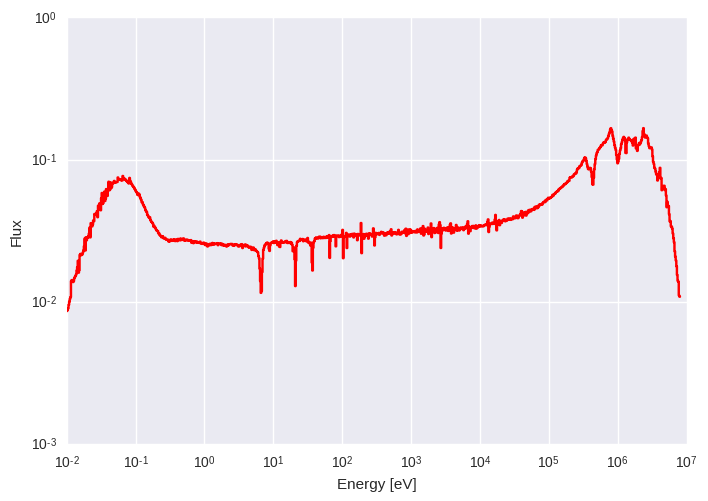

In [19]:
fig = plt.figure()
plt.loglog(energies, fluxes, drawstyle='steps', c='r')
plt.xlabel('Energy [eV]')
plt.ylabel('Flux')

## Potting mesh tallies

Mesh tallies can be quickly plotted with the `matplotlib.imshow` function.

In [20]:
df = mesh_fiss.get_pandas_dataframe()
df.head(5)

mesh 10000       nuclide    score      mean std. dev.
           x  y  z                                     
0          1  1  1    U235  fission  0.001659  0.000028
1          1  1  1    U238  fission  0.000104  0.000001
2          1  2  1    U235  fission  0.001684  0.000026
3          1  2  1    U238  fission  0.000103  0.000001
4          1  3  1    U235  fission  0.001693  0.000032

In [21]:
mean = df[df['nuclide'] == 'U235']['mean'].values
rel_err = df[df['nuclide'] == 'U235']['std. dev.'].values / mean

In [22]:
# Reshape the arrays.
mean.shape = (17, 17)
rel_err.shape = (17, 17)

# Transpose them to match the order expected by imshow.
mean = mean.T
rel_err = rel_err.T

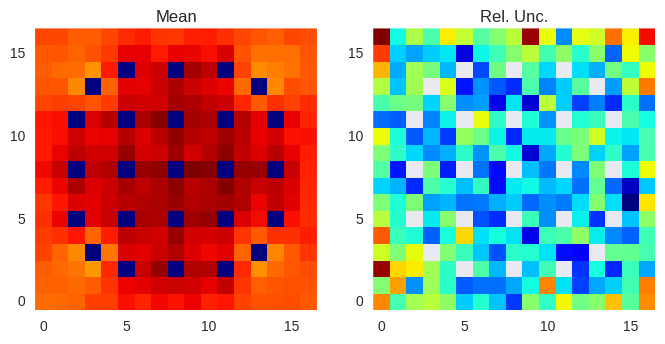

In [23]:
# Plot the mean on the left.
fig = plt.subplot(121)
plt.imshow(mean, interpolation='none', cmap='jet')
plt.ylim(plt.ylim()[::-1])  # Invert the y-axis.
plt.title('Mean')
plt.grid(False)

# Plot the uncertainty on the right.
fig2 = plt.subplot(122)
plt.imshow(rel_err, interpolation='none', cmap='jet')
plt.ylim(plt.ylim()[::-1])  # Invert the y-axis.
plt.title('Rel. Unc.')
plt.grid(False)

This mesh tally of fission rates particularly informative since the dark blue guide tube do not have any fission and skew the color bar. We can rectify this issue with a little trick to Matplotlib's color scheme as follows.

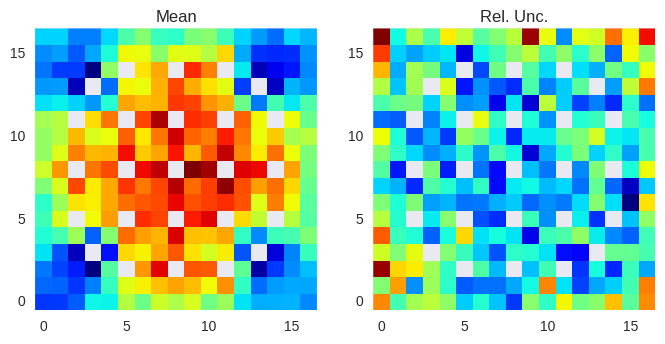

In [24]:
# Assign a NaN to zero fission rates in guide tubes
# Matplotlib will ignore "bad" values in the colorbar
mean[mean == 0.] = np.nan
cmap = plt.get_cmap('jet')
cmap.set_bad(alpha=0.)

# Plot the mean on the left.
fig = plt.subplot(121)
plt.imshow(mean, interpolation='none', cmap='jet')
plt.ylim(plt.ylim()[::-1])  # Invert the y-axis.
plt.title('Mean')
plt.grid(False)

# Plot the uncertainty on the right.
fig2 = plt.subplot(122)
plt.imshow(rel_err, interpolation='none', cmap='jet')
plt.ylim(plt.ylim()[::-1])  # Invert the y-axis.
plt.title('Rel. Unc.')
plt.grid(False)

## Other ways to get tally data

Note that Pandas DataFrames are not the only way to interact with tally data!  If DataFrames do not work with your use case, try the `Tally.get_value()` method or accessing `Tally.mean` and `Tally.std_dev` directly.